# FYSS5403 Homework 4, Otto Salmenkivi

## Excercise 1

Lets build a general QFT function

In [172]:
from qiskit import *
from numpy import pi
from qiskit.visualization import plot_bloch_multivector, plot_histogram
from qiskit.tools.monitor import job_monitor
IBMQ.load_account()
provider = IBMQ.get_provider('ibm-q')

ibmqfactory.load_account:WARNING:2020-11-26 17:38:38,265: Credentials are already in use. The existing account in the session will be replaced.


In [173]:
n = 3 # Number of qubits in the system

# A general QFT function that aplies QFT on all of the qubits in the circuit
def qft(circuit):
    n = circuit.num_qubits
    while n > 0:
        circuit.h(n-1)
        for control in reversed(range(n-1)):
            circuit.cp(pi/2**(n-control-1),control,n-1)

        circuit.barrier()
        n -= 1
    mirror(circuit)
    return circuit

def mirror(circuit):
    n = circuit.num_qubits
    for i in range(circuit.num_qubits//2):
        circuit.swap(i,n-i-1)
        i += 1
    return circuit
    

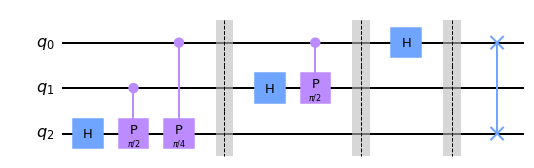

In [174]:
qft_circuit = qft(QuantumCircuit(n))
qft_circuit.draw( output = 'mpl')

Alright, now that we a working fucction, let's do something with it. Let's choose number 1 $\Leftrightarrow|001\rangle$ and visualize the statevector before and after the QFT.

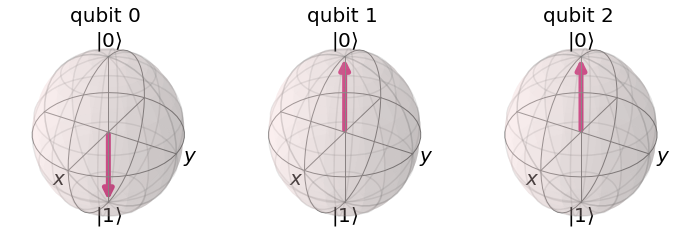

In [168]:
# Qauntum circuit for 001
qc = QuantumCircuit(n)
qc.x(0)
qc.barrier()

# Simulation for 001
backend = Aer.get_backend('statevector_simulator')
statevector = execute(qc, backend=backend).result().get_statevector()
plot_bloch_multivector(statevector)

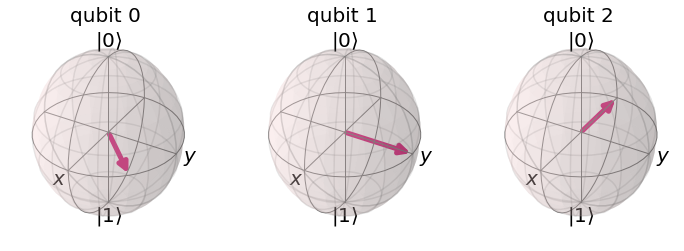

In [169]:
# Simulation in Fourier basis.
qc += qft_circuit
backend = Aer.get_backend('statevector_simulator')
statevector = execute(qc, backend=backend).result().get_statevector()
plot_bloch_multivector(statevector)

We can see that the statevectors have been mapped to Fourier basis. The same code can be used for any number of qubits  $n$, but the initial state has to be input by hand.  
  
To test it on real quantum hardware, we need to run the reverse QTF on the state that we got after QFT on state $|001\rangle$.

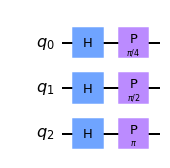

In [179]:
# Preparing the state QFT|001>
qc = QuantumCircuit(n)
for i in range(qc.num_qubits):
    qc.h(i)
qc.p(pi/4,0)
qc.p(pi/2,1)
qc.p(pi,2)

qc.draw(output = 'mpl')

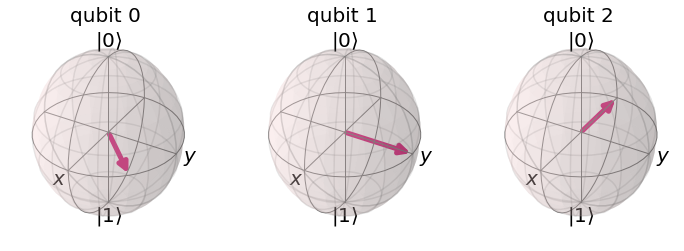

In [180]:
statevector = execute(qc, backend=backend).result().get_statevector()
plot_bloch_multivector(statevector)

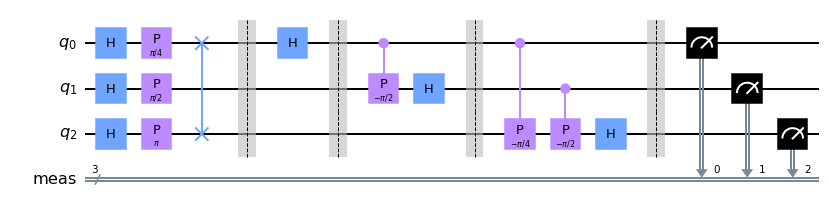

In [181]:

qc += qft(QuantumCircuit(n)).inverse()
qc.measure_all()
qc.draw(output = 'mpl')

This can be run on quantum computer to check if the QFT was correct.

In [166]:
# Algorithm for least busy from Moodle notes
from qiskit.providers.ibmq import least_busy

small_devices = provider.backends(filters=lambda x: x.configuration().n_qubits == 5
                                   and not x.configuration().simulator)
qcomp = least_busy(small_devices)
print('The backend in use is',qcomp)

The backend in use is ibmq_valencia


In [167]:
job = execute(qc, backend=qcomp)
job_monitor(job)
counts = job.result().get_counts()


Job Status: job has successfully run


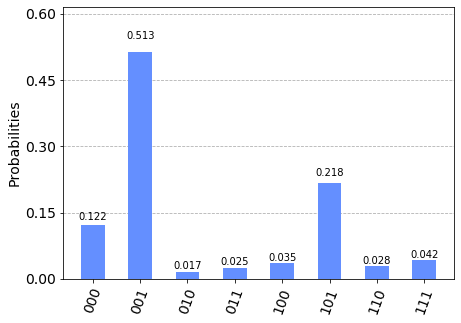

In [156]:
plot_histogram(counts)

We see that the reverse QFT gives us the state $|001\rangle$, which is correct, so the QFT works.

## Excercise 2 Shor's Algorithm
Mostly copied from example, I will highlight my own work.
### a = 3 , N = 10


In [2]:
import matplotlib.pyplot as plt
from math import gcd
from numpy.random import randint
import pandas as pd
from fractions import Fraction

In [43]:
def qft_dagger(n):
    """n-qubit QFTdagger the first n qubits in circ"""
    qc = QuantumCircuit(n)
    # Don't forget the Swaps!
    for qubit in range(n//2):
        qc.swap(qubit, n-qubit-1)
    for j in range(n):
        for m in range(j):
            qc.cu1(-np.pi/float(2**(j-m)), m, j)
        qc.h(j)
    qc.name = "QFT†"
    return qc
#These gates are for a = 3, N = 10. 
def U12():
    """Controlled multiplication by 9 mod 10"""
    U = QuantumCircuit(4)   
    U.x(3)
    U = U.to_gate()
    U.name = "U2" 
    c_U = U.control()
    return c_U

def U11():
    """Controlled multiplication by 9 mod 10"""
    U = QuantumCircuit(4)   
    U.x(1)
    U.swap(3,2)
    U = U.to_gate()
    U.name = "U1" 
    c_U = U.control()
    return c_U

In [44]:
# MY WORK, lest build the circuit, 3 counting qubits
n_count = 3
qc = QuantumCircuit(n_count + 4,3)
for i in range(n_count):
    qc.h(i)
qc.x(qc.num_qubits-1)
qc.append(U11(),[1] + [i + n_count for i in range(4)])
qc.append(U12(),[2] + [i + n_count for i in range(4)])
qc.append(qft_dagger(n_count), range(3))
qc.measure(range(n_count),qc.clbits)
qc.draw()

/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: The QuantumCircuit.cu1 method is deprecated as of 0.16.0. It will be removed no earlier than 3 months after the release date. You should use the QuantumCircuit.cp method instead, which acts identically.
  if __name__ == '__main__':


┌───┐              ┌───────┐┌─┐      
q_0: ┤ H ├──────────────┤0      ├┤M├──────
     ├───┤              │       │└╥┘┌─┐   
q_1: ┤ H ├───■──────────┤1 QFT† ├─╫─┤M├───
     ├───┤   │          │       │ ║ └╥┘┌─┐
q_2: ┤ H ├───┼──────■───┤2      ├─╫──╫─┤M├
     └───┘┌──┴──┐┌──┴──┐└───────┘ ║  ║ └╥┘
q_3: ─────┤0    ├┤0    ├──────────╫──╫──╫─
          │     ││     │          ║  ║  ║ 
q_4: ─────┤1    ├┤1    ├──────────╫──╫──╫─
          │  U1 ││  U2 │          ║  ║  ║ 
q_5: ─────┤2    ├┤2    ├──────────╫──╫──╫─
     ┌───┐│     ││     │          ║  ║  ║ 
q_6: ┤ X ├┤3    ├┤3    ├──────────╫──╫──╫─
     └───┘└─────┘└─────┘          ║  ║  ║ 
c: 3/═════════════════════════════╩══╩══╩═
                                  0  1  2

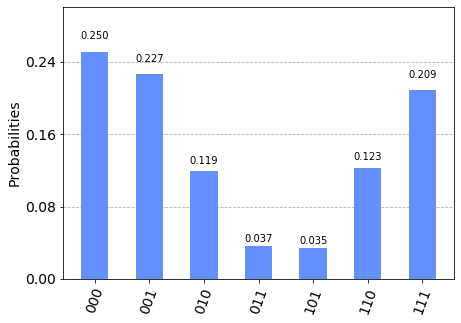

In [45]:
backend = Aer.get_backend('qasm_simulator')
results = execute(qc, backend, shots=2048).result()
counts = results.get_counts()
plot_histogram(counts)

In [28]:

rows, measured_phases = [], []
for output in counts:
    decimal = int(output, 2)  # Convert (base 2) string to decimal
    phase = decimal/(2**n_count) # Find corresponding eigenvalue
    measured_phases.append(phase)
    # Add these values to the rows in our table:
    rows.append(["%s(bin) = %i(dec)" % (output, decimal), 
                 "%i/%i = %.2f" % (decimal, 2**n_count, phase)])
# Print the rows in a table
headers=["Register Output", "Phase"]
df = pd.DataFrame(rows, columns=headers)
print(df)

     Register Output       Phase
0  000(bin) = 0(dec)  0/8 = 0.00
1  001(bin) = 1(dec)  1/8 = 0.12
2  010(bin) = 2(dec)  2/8 = 0.25
3  011(bin) = 3(dec)  3/8 = 0.38
4  101(bin) = 5(dec)  5/8 = 0.62
5  110(bin) = 6(dec)  6/8 = 0.75
6  111(bin) = 7(dec)  7/8 = 0.88


In [29]:
rows = []
for phase in measured_phases:
    frac = Fraction(phase).limit_denominator(15)
    rows.append([phase, "%i/%i" % (frac.numerator, frac.denominator), frac.denominator])
# Print as a table
headers=["Phase", "Fraction", "Guess for r"]
df = pd.DataFrame(rows, columns=headers)
print(df)

   Phase Fraction  Guess for r
0  0.000      0/1            1
1  0.125      1/8            8
2  0.250      1/4            4
3  0.375      3/8            8
4  0.625      5/8            8
5  0.750      3/4            4
6  0.875      7/8            8


So we get most hits to r = 8, which is correct.

### a = 2 , N = 9
With similar reasoning to a = 3 and N = 10, we can build gates that correspond to a = 2 and N = 9.  
  
$
U_a|y\rangle = |ay \text{ mod } N\rangle \\
$  

For the first gate:
$
U_2|1\rangle = |2\text{ mod }9\rangle = |0010\rangle$ this means $|0001\rangle \rightarrow |0010\rangle
$, which we can implement with SWAP(1,0).
  
  
For the second gate:  
$
\begin{cases}
U_2^2|1\rangle = |4\text{ mod }9\rangle = |4\rangle = |0100\rangle \\
U_2^2|2\rangle = |8\text{ mod }9\rangle = |8\rangle = |1000\rangle
\end{cases}
\Longrightarrow
\begin{cases}
|0001\rangle \rightarrow |0100\rangle \\
|0010\rangle \rightarrow |1000\rangle
\end{cases}
$  
  
This can be implemented by SWAP(2,0)SWAP(1,3). For the third and final gate we have:

  
$
\begin{cases}
U_2^3|1\rangle =|8\text{ mod }9\rangle \: \: = |8\rangle =|1000\rangle\\
U_2^3|4\rangle =|32\text{ mod }9\rangle = |5\rangle =|0101\rangle\\
U_2^3|8\rangle =|64\text{ mod }9\rangle = |1\rangle =|0001\rangle
\end{cases}
\Longrightarrow
\begin{cases}
|0001\rangle \rightarrow |1000\rangle \\
|0100\rangle \rightarrow |0101\rangle \\
|1000\rangle \rightarrow |0001\rangle
\end{cases}
$
  
This can be implemented with CX(2,0)SWAP(3,0).

In [50]:
# MY WORK
def U23():
    """Controlled multiplication by 2 mod 9"""
    U = QuantumCircuit(4)   
    U.swap(1,0)
    U = U.to_gate()
    U.name = "U23" 
    c_U = U.control()
    return c_U

def U22():
    """Controlled multiplication by 2 mod 9"""
    U = QuantumCircuit(4)   
    U.swap(1,3)
    U.swap(0,2)
    U = U.to_gate()
    U.name = "U22" 
    c_U = U.control()
    return c_U

def U21():
    """Controlled multiplication by 2 mod 9"""
    U = QuantumCircuit(4) 
    U.cx(2,0)
    U.swap(3,0)
    U = U.to_gate()
    U.name = "U21" 
    c_U = U.control()
    return c_U
    

In [59]:
# MY WORK, lest build the circuit, 3 counting qubits
n_count = 3
qc = QuantumCircuit(n_count + 4,3)
for i in range(n_count):
    qc.h(i)
qc.x(qc.num_qubits-1)
qc.append(U23(),[0] + [i + n_count for i in range(4)])
qc.append(U22(),[1] + [i + n_count for i in range(4)])
qc.append(U21(),[2] + [i + n_count for i in range(4)])
qc.append(qft_dagger(n_count), range(3))
qc.measure(range(n_count),qc.clbits)
qc.draw()


/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: The QuantumCircuit.cu1 method is deprecated as of 0.16.0. It will be removed no earlier than 3 months after the release date. You should use the QuantumCircuit.cp method instead, which acts identically.
  if __name__ == '__main__':


┌───┐                        ┌───────┐┌─┐      
q_0: ┤ H ├───■────────────────────┤0      ├┤M├──────
     ├───┤   │                    │       │└╥┘┌─┐   
q_1: ┤ H ├───┼───────■────────────┤1 QFT† ├─╫─┤M├───
     ├───┤   │       │            │       │ ║ └╥┘┌─┐
q_2: ┤ H ├───┼───────┼───────■────┤2      ├─╫──╫─┤M├
     └───┘┌──┴───┐┌──┴───┐┌──┴───┐└───────┘ ║  ║ └╥┘
q_3: ─────┤0     ├┤0     ├┤0     ├──────────╫──╫──╫─
          │      ││      ││      │          ║  ║  ║ 
q_4: ─────┤1     ├┤1     ├┤1     ├──────────╫──╫──╫─
          │  U23 ││  U22 ││  U21 │          ║  ║  ║ 
q_5: ─────┤2     ├┤2     ├┤2     ├──────────╫──╫──╫─
     ┌───┐│      ││      ││      │          ║  ║  ║ 
q_6: ┤ X ├┤3     ├┤3     ├┤3     ├──────────╫──╫──╫─
     └───┘└──────┘└──────┘└──────┘          ║  ║  ║ 
c: 3/═══════════════════════════════════════╩══╩══╩═
                                            0  1  2

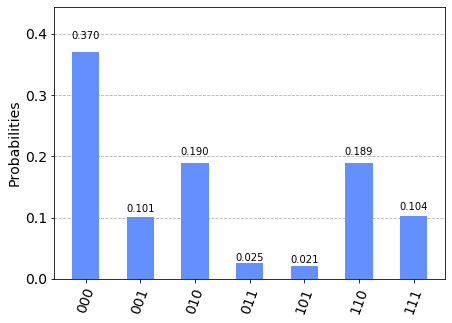

In [60]:
backend = Aer.get_backend('qasm_simulator')
results = execute(qc, backend, shots=2048).result()
counts = results.get_counts()
plot_histogram(counts)

In [61]:

rows, measured_phases = [], []
for output in counts:
    decimal = int(output, 2)  # Convert (base 2) string to decimal
    phase = decimal/(2**n_count) # Find corresponding eigenvalue
    measured_phases.append(phase)
    # Add these values to the rows in our table:
    rows.append(["%s(bin) = %i(dec)" % (output, decimal), 
                 "%i/%i = %.2f" % (decimal, 2**n_count, phase)])
# Print the rows in a table
headers=["Register Output", "Phase"]
df = pd.DataFrame(rows, columns=headers)
print(df)

     Register Output       Phase
0  000(bin) = 0(dec)  0/8 = 0.00
1  001(bin) = 1(dec)  1/8 = 0.12
2  010(bin) = 2(dec)  2/8 = 0.25
3  011(bin) = 3(dec)  3/8 = 0.38
4  101(bin) = 5(dec)  5/8 = 0.62
5  110(bin) = 6(dec)  6/8 = 0.75
6  111(bin) = 7(dec)  7/8 = 0.88


In [62]:
rows = []
for phase in measured_phases:
    frac = Fraction(phase).limit_denominator(15)
    rows.append([phase, "%i/%i" % (frac.numerator, frac.denominator), frac.denominator])
# Print as a table
headers=["Phase", "Fraction", "Guess for r"]
df = pd.DataFrame(rows, columns=headers)
print(df)

   Phase Fraction  Guess for r
0  0.000      0/1            1
1  0.125      1/8            8
2  0.250      1/4            4
3  0.375      3/8            8
4  0.625      5/8            8
5  0.750      3/4            4
6  0.875      7/8            8


WolframAlfa says $2^x \text{ mod } 9 = 1 \;\Rightarrow\; x  = 6$. So, I'm not sure where I go wrong. 